<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Style and Markdown guide for DSI Lessons/Labs

_Authors: Dave Yerrington (SF), Joseph Nelson (DC), Kiefer Katovich (SF)_

---

### Learning Objectives
- **Describe** test/train/split and cross-validation
- **Explain** why we want to use these validation techniques and how they differ
- **Split** data into testing and training sets using both test/train/split and cross validation and **Apply** both techniques to score a model

### Lesson Guide
- [Overfitting and underfitting](#overfitting-underfitting)
- [Train-test split](#train-test-split)
- [K-Fold cross-validation](#cross-val-k-fold)
- [Train-test-split demonstration](#demo)
    - [Plot a heatmap](#heatmap)
    - [Select a single predictor for SLR](#single-predictor)
    - [Split data into training and testing](#sklearn-tts)
    - [Fit on the training data](#fit-on-train)
- [K-Fold cross-validation demonstration](#cv-demo)
- [Review: negative $R^2$ values](#neg-r2)
- [Hold-out sets](#hold-out)
- [Additional resources](#additional-resources)

<a id='overfitting-underfitting'></a>

## Overfitting and underfitting

---

![](http://tomrobertshaw.net/img/2015/12/overfitting.jpg)


**What is wrong with the first model?**
- The underfit model falls short of capturing the complexity of the "true model" of the data.

**What is wrong with the third model?**
- The overfit model is too complex and is modeling random noise in the dat.

**Middle model is a good compromise.**
- It approximates the complexity of the true model and does not model random noise in our sample as true relationships.

![](http://image.slidesharecdn.com/nncollovcapaldo2013-131220052427-phpapp01/95/machine-learning-introduction-to-neural-networks-12-638.jpg?cb=1393073301)

<a name="train-test-split"></a>
## Train-test split and model validation

---

So far we've focused on fitting the best model to our data. But is this the best model for our sample data or the best model overall? How do we know?

In practice, we need to validate our model's ability to generalize to new data. One very popuplar method for performing model validation is by splitting our data into subsets: data that we *train* our model on, and data that we *test* our model on.

The most basic type of "hold-out" validation is called **train-test split**. We split our data into two pieces:

> **"Training set":** the subset of the data that we fit our model on.

> **"Testing set":** the subset of the data that we evaluate the quality of our predictions on.


**Test/train split benefits:**
- Testing data can be a proxy for "future" data; for prediction-oriented models it is critical to make sure a model performing well on current data will likely perform well on future data.
- Can help diagnose and avoid overfitting via model tuning.
- Improve the quality of our predictions.

<a id='cross-val-k-fold'></a>

## K-Fold cross-validation

---

K-Fold cross-validation takes the idea of a single train-test split and expands this to *multiple tests* across different train-test splits of your data.

For example, if you determine your training set will contain 80% of the data and your testing set will contain the other 20%, you could have 5 different 80/20 splits where the test set in each is different sets of observations. We have:
- 5 (K=5) training sets
- 5 (K=5) corresponding test sets

**K-Fold cross-validation builds K models, one for each train-test pair, and evaluates those models on each respective test-set.**

### K-Fold cross-validation visually

<img src="https://snag.gy/o1lLcw.jpg?convert_to_webp=true" width="500"a>

---

Cross-validation helps us understand how a model parameterization may perform in a variety of cases. The K-Fold cross-validation procedure can be described in pseudocode:

```
set k
create k groups of rows in data

for group i in k row groups:
    test data is data[group i]
    train data is data[all groups not i]
    
    fit model on train data
    
    score model on test data
    
evaluate mean of k model scores
evaluate variance of k model scores
```

Odd case #1:
> **When K=2**: This is equivalent to doing ***two*** mirror image 50-50 train-test splits.

Odd case #2:
> **When K=number of rows**: This is known as "leave one out cross-validation" or LOOCV. A model is built on all but one row and tested on the single held-out observation.

<a id='demo'></a>

## Train-test split with sklearn demonstration

---

Let's use sklearn to load everyone's favorite data set: the boston housing data.

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')


In [3]:
# A:
boston=datasets.load_boston()
boston.keys()

['data', 'feature_names', 'DESCR', 'target']

In [6]:
df=pd.DataFrame(boston.data,columns=boston.feature_names)
y=boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### Plot a heatmap of the correlation matrix

Heatmaps are a great way to visually examine the correlational structure of your predictors. 

> Keep in mind that pearson correlation between non-dummy-coded categorical variables and other variables are invalid!

Let's lift some code from GitHub Gist to plot a correlation heat map.

[Ryan's Heatmap Cheat Sheet](https://gist.github.com/rddunlap23/02d4014907ffaf9cbdf49f4004f82ba6)

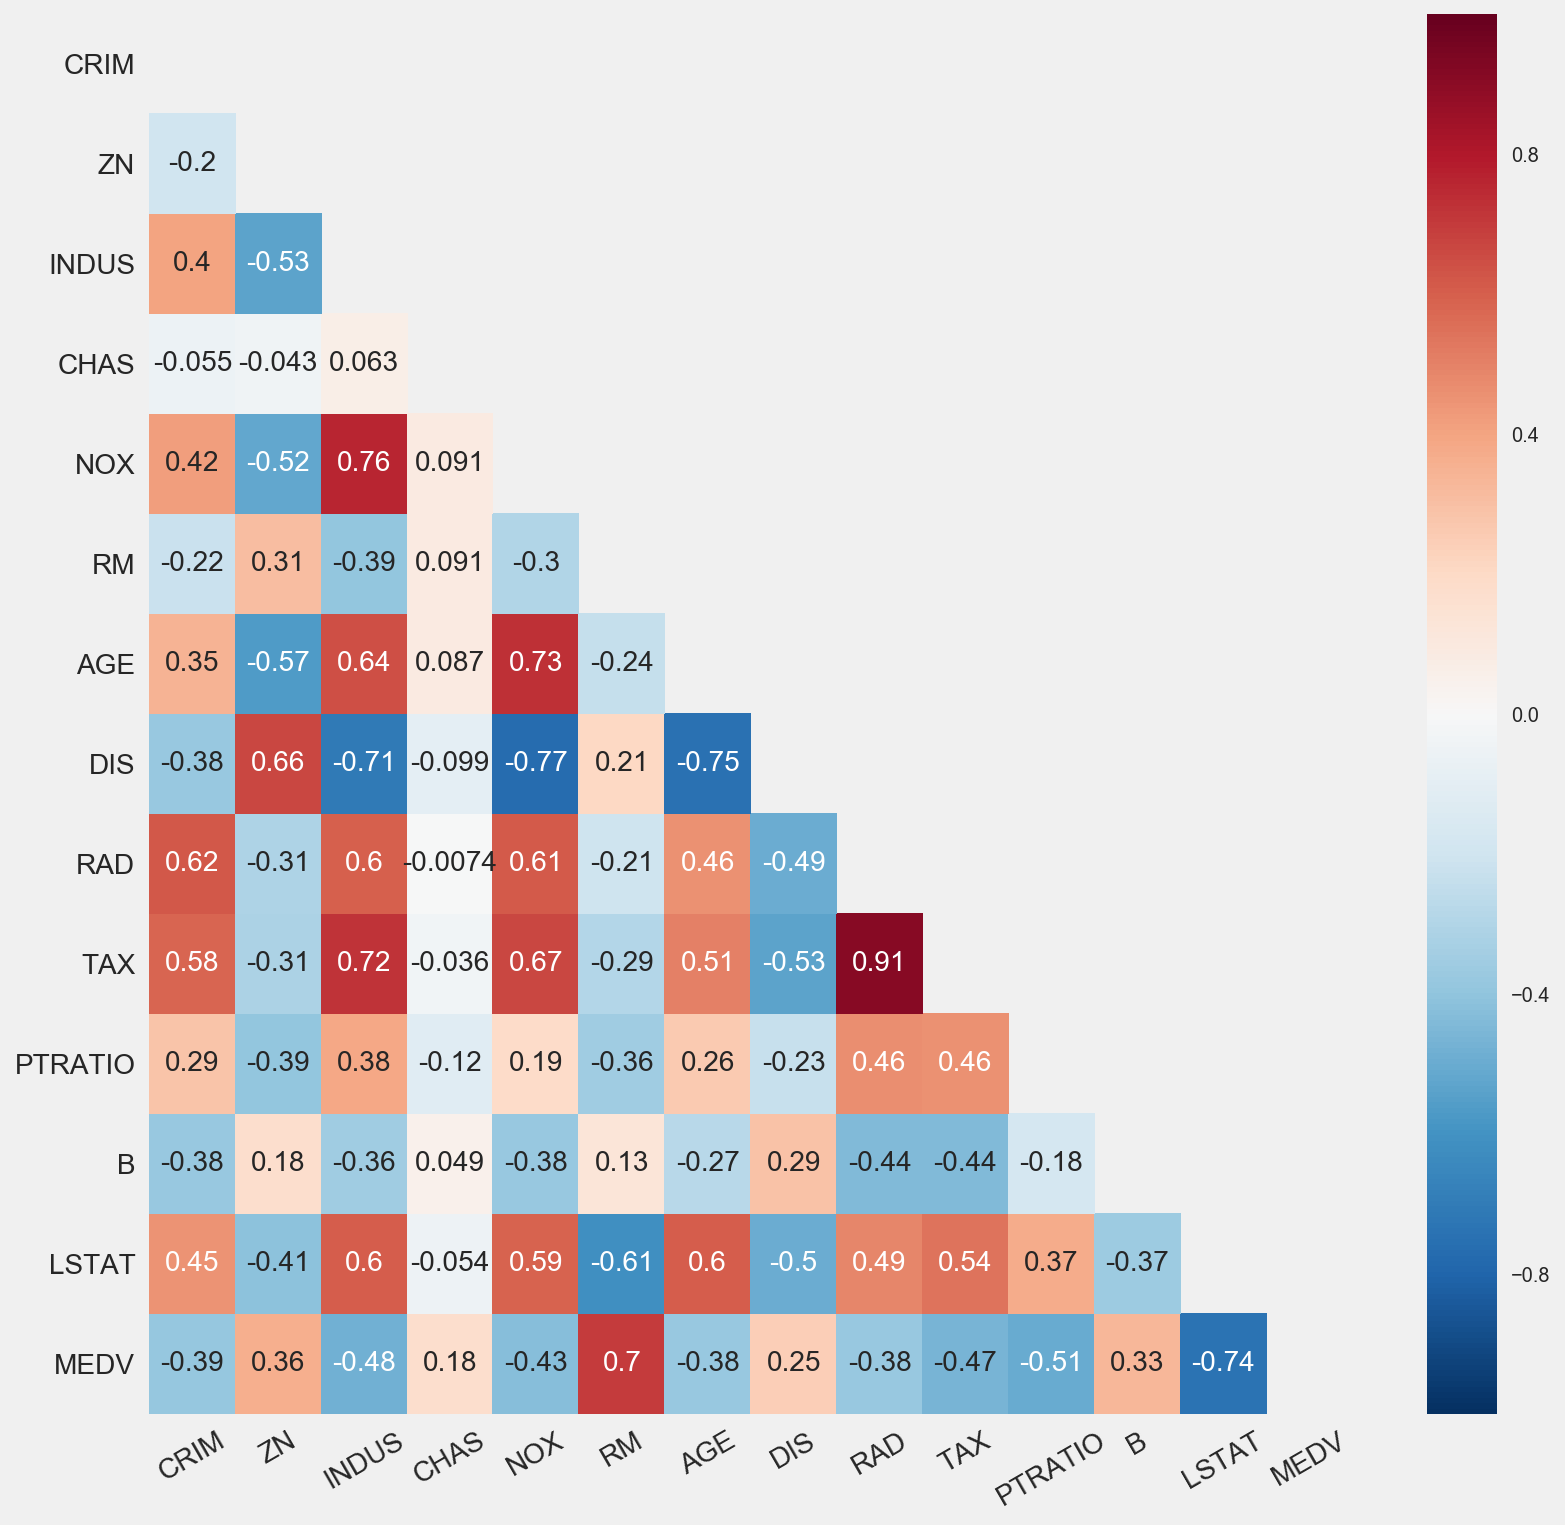

In [8]:
# A:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
df_with_target = df.copy()
df_with_target['MEDV'] = y
correlation_heat_map(df_with_target)



<a id='single-predictor'></a>

### Select a single predictor for a SLR

The variable `AGE` appears to have a minor linear relationship with the target variable, `MEDV`.

Let's select just `AGE` out of the data as a single column design matrix.

In [11]:
# A:
x=df[['AGE']]
x.head()

,AGE
0,65.2
1,78.9
2,61.1
3,45.8
4,54.2


**Good practice to plot the variable against the target to confirm the relationship visually.**

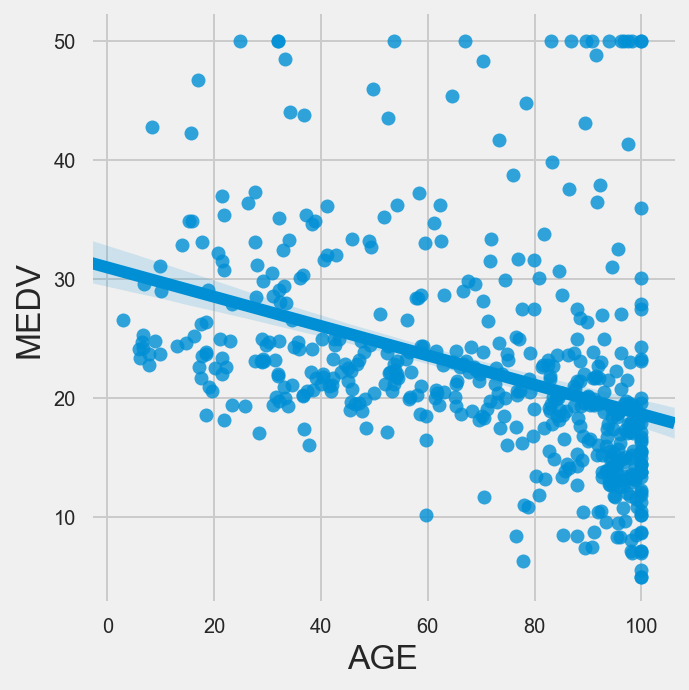

In [13]:
# A:
sns.lmplot('AGE','MEDV',df_with_target)

<a id='sklearn-tts'></a>

### sklearn's `train_test_split` function

Train test split using sklearn is easy. Load the `train_test_split` function:

```python
from sklearn.model_selection import train_test_split
```

**Arguments**:
- *arrays: Any number of arrays/matrices to split up into training and testing (they should be the same length).
- `test_size`: an integer for exact size of the test subset or a float for a percentage
- `train_size`: alternatively you can specify the training size
- `stratify`: supply a vector to stratify the splitting by (more important in classification tasks)

**Perform a 50-50 split of our `X` and `y`:**

In [6]:
from sklearn.model_selection import train_test_split

In [14]:
# A:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.5)


In [15]:
print x_train.shape, x_test.shape
print y_train.shape,y_test.shape

(253, 1) (253, 1)
(253,) (253,)


Note that we could always split the data up manually. Here's an example for [this dataset](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py) of manual splitting code.

<a id='fit-on-train'></a>

### Fit a linear regression on the training set

Using the training `X` and training `y`, we can fit a linear regression with sklearn's `LinearRegression`.

In [17]:
from sklearn.linear_model import LinearRegression


In [18]:
# A:
lr=LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

<a id='score-on-test'></a>

### Calculate the $R^2$ score on the test data

After we have our model constructed on the training set, we can evaluate how well our model performs on data it has no exposure to.

In [19]:
# A:
lr.score(x_test,y_test)

0.096711458511212989

**Compare this to the model scored on the training set.**

In [20]:
# A:
lr.score(x_train,y_train)

0.16423266365726574

<a id='cv-demo'></a>

## K-Fold cross-validation demonstration

---


Now let's try out k-fold cross-validation. Again scikit-learn provides useful functions to do the heavy lifting. 

The function `cross_val_score` returns the $R^2$ for each test set. 

Alternatively, the function `cross_val_predict` returns the predicted values for each data point when it's in the testing slice.


In [12]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics


//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# A:

<a id='neg-r2'></a>
## Review: negative $R^2$ values

---

What does it mean to have a negative $R^2$?

A negative $R^2$ only makes sense (and can only be found) when we are evaluating the $R^2$ score on data that the model was not fit on. If $R^2$ is evaluated for a model using the training data, *the minimum $R^2$ must be zero.* 

However, on a test set the $R^2$ **can** be negative. This means that the model performs so poorly on the testing set that you would have been better off just using the mean of the target from the training set as an estimate!

<a id='hold-out'></a>

## Hold-out sets

---

Hold-out sets are a version of train-test split. The concept of having a hold-out set is:
1. **Split data into a large train and small test set. This small test set will be the "hold-out" set.**
2. **For a set of different model parameterizations:**
    1. **Set up the model.**
    2. **Cross-validate the current model on the training data.**
    3. **Save the model performance.**
3. **Select the model that performed best using cross-validation on the training data.**
4. **Perform a final test of that model on the original "hold-out" test set.**

> **Note:** The "hold-out" method is more conservative, but also requires that you have more data. With smaller datasets it can be infeasable.

The graphic below explains the hold-out method visually.

![](./assets/Train-Test-Split-CV.png)

<a id='additional-resources'></a>

## Additional Resources

---

- [Cross-validation Example](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py)
- [Plotting Cross-Validated Predictions](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html)
- Examine this [academic paper](http://frostiebek.free.fr/docs/Machine%20Learning/validation-1.pdf) on the underpinnings of the holdout method, LOOVC, and kfolds
- The sklearn [documentation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) on cross validation is strong
- This [Stanford lesson](https://www.youtube.com/watch?v=_2ij6eaaSl0) on cross validation
- This [blog post](http://www.win-vector.com/blog/2015/01/random-testtrain-split-is-not-always-enough/) on why TTS is not always enough
- StackExchange [discussion](http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio) on approximate TTS, validation set sizes